In [76]:
!pip install ta
!pip install load_dotenv

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
from IPython.display import clear_output
import datetime
import pytz
import ta
from statsmodels.tsa.arima.model import ARIMA
import pickle
import csv
import os
from dotenv import load_dotenv
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.dates as mdates
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import GridSearchCV

In [78]:
# Cargar las variables de entorno desde el archivo .env
load_dotenv('/content/drive/MyDrive/ProfeAlejo/Challenge_1/config/.env')
API_KEY = os.getenv('API_KEY')  # API Key de Polygon.io

In [79]:
def get_df_bitcoin(coin):

  symbol = coin
  period = 2000 # número de dias históricos a obtener
  interval = 5 # intervalo de minutos
  exchange = "USD"

  url = f'https://min-api.cryptocompare.com/data/v2/histominute?fsym={symbol}&tsym={exchange}&aggregate={interval}&limit={period}&api_key={API_KEY}'

  # df = requests.get(url).json()['Data']

  response = requests.get(url)

  data = response.json()


  df = pd.DataFrame(data["Data"]["Data"])

  # Convierte el valor de la columna `time` a un objeto `datetime`.
  df["time"] = pd.to_datetime(df["time"], unit="s")
  df["time"] = df["time"].dt.tz_localize("UTC")

  # Formatee el valor de la columna `time` en el formato `"%Y-%m-%d %H:%M"`.
  df["time"] = df["time"].dt.strftime("%H:%M")

  df['close'] = df['close'].astype(int)

  df = df[["time", "high",'low','open','volumefrom','volumeto', 'close']]

  # Guardar los datos en un dataframe
  df_bitcoin = pd.DataFrame(df)

  # Calcular indicadores
  df_bitcoin["rsi"] = (ta.momentum.RSIIndicator(df_bitcoin["close"]).rsi()).round(0)
  df_bitcoin["macd"] = (ta.trend.MACD(df_bitcoin["close"]).macd()).round(0)
  df_bitcoin["macd_signal"] = (ta.trend.MACD(df_bitcoin["close"]).macd_signal()).round(0)

  return df_bitcoin

In [80]:
def get_df_bitcoin_limpio(coin):

    df_data=get_df_bitcoin(coin)

    # 2 - Crear df con columnas: DataTime - Close - Volume
    df_bitcoin_limpio= df_data[['time','close','volumeto','rsi','macd','macd_signal']]

    # 3 - Eliminar filas con volume=0
    df = df_bitcoin_limpio[df_bitcoin_limpio['volumeto'] != 0]

    # 4 - Encontrar los índices duplicados
    duplicados = df.index.duplicated()

    # Eliminar las filas duplicadas
    df = df[~duplicados]

    # 5 - Elimina filas con Close=0
    df_bitcoin_limpio = df[df['close'] != 0]

    return df_bitcoin_limpio

In [81]:
def between_quartiles(coin):
    df=get_df_bitcoin_limpio(coin)
    cuartiles = [0, 0.25, 0.5, 0.75, 1]

    try:
        valores = df['close'].quantile(cuartiles)
    except ValueError:
        return None

    if math.isnan(valores[0.25]) or math.isnan(valores[0.75]):
        return None

    df_bitcoin_cuartiles = df.query('close > ' + str(int(valores[0.25])) + ' & close < ' + str(int(valores[0.75])))

    return df_bitcoin_cuartiles

In [82]:
def extraer_tendencias(btc):
    global precio_actual, tendencia

    time.sleep(5)

    # Hacer la petición GET a la página web
    page = requests.get(f'https://www.coincarp.com/currencies/{btc}')

    # Crear el objeto BeautifulSoup a partir del HTML de la página web
    soup = BeautifulSoup(page.content, 'html.parser')

    # Encontrar el precio actual del Bitcoin
    precio = soup.find('span', {'id': 'coin-lastticker'}).text.strip().replace('$', '').replace(',', '')
    precio_actual = float(precio)

    # Análisis de tendencia a partir del icono up o down
    span_element = soup.find('div', {'class': ['cryptocurrencies-price d-flex align-items-center']}).find('button')
    i_element = span_element.find('i')

    if 'icon iconfont icon-solid-arrow-up' in i_element['class']:
      tendencia = 'alta'
    else:
      tendencia = 'baja'

    # Encontrar la variación del precio 24hs
    porcentaje = span_element.text.strip().replace('$', '').replace(',', '')

    return [precio_actual, tendencia, porcentaje]

In [83]:
def tomar_decisiones(coin,btc):
    global symbol, period, interval, df_bitcoin, precio_actual, tendencia, media,rsi,macd,macdsignal,ma50,ma200

    df=between_quartiles(coin)
    if df is None:
        decision = "Sin datos"
        explicacion = "Explicación: No hay suficientes datos para tomar una decisión clara y asertiva. Los datos RSI, MACD y SiGNAL no cubren lo suficiente. Se recomienda buscar otra moneda o esperar a que haya más datos disponibles."
        return f"La decisión para este caso es: {decision}, ya que su {explicacion}"

    df = df[ ['close','volumeto','rsi','macd','macd_signal'] ] # ordenamos columnas

    # Último RSI
    rsi=df.iat[-1, 2]
    # Últimol MACD
    macd=df.iat[-1, 3]
    # Último MACD-SIGNAL
    macdsignal = df.iat[-1, 4]

    # Calcular la media móvil de 50 días y 200 días
    df["ma50"] = df["close"].rolling(50).mean()
    df["ma200"] = df["close"].rolling(200).mean()

    ma50=df["ma50"].iloc[-1]
    ma200=df["ma200"].iloc[-1]

    #Precio actual
    precio = extraer_tendencias(btc)[0]
    #Tendencia actual
    tendencia=extraer_tendencias(btc)[1]
    #media
    media = df['close'].mean()

    # Aplicar el criterio de decisión

    if precio > media and rsi > 50 and macd > macdsignal and precio > ma50 and precio > ma200:
        decision = "Comprar"
        explicacion ="Explicación: El precio actual está por encima de la media, el RSI es alto, el MACD está por encima de su señal,\n el precio actual está por encima de la MA50 y la MA200, lo que indica una tendencia alcista fuerte y una buena oportunidad para comprar."
    elif precio < media and rsi < 50 and macd < macdsignal and precio < ma50 and precio < ma200:
        decision = "Vender"
        explicacion ="Explicación: El precio actual está por debajo de la media, el RSI es bajo, el MACD está por debajo de su señal,\n el precio actual está por debajo de la MA50 y la MA200, lo que indica una tendencia bajista fuerte y una buena oportunidad para vender."
    else:
      decision = "Mantener"
      if tendencia == "Alta":
          if precio > media and precio > ma50 and precio > ma200:
              explicacion ="Explicación: El precio actual está por encima de la media, la MA50 y la MA200, lo que indica una tendencia alcista. Aunque el RSI y el MACD no son muy altos, se recomienda mantener ya que la tendencia general es positiva y puede haber potencial para ganancias adicionales."

          elif precio < media and precio < ma50 and precio < ma200:
                explicacion ="Explicación: El precio actual está por debajo de la media, la MA50 y la MA200, lo que indica una tendencia bajista. Aunque el RSI y el MACD no son muy bajos, se recomienda mantener ya que la tendencia general es negativa y puede haber potencial para disminución adicional en las pérdidas."

          else:
              explicacion ="Explicación: Aunque la tendencia general es alcista, el precio actual no está lo suficientemente por encima de la media, la MA50 y la MA200 para justificar una compra adicional. Sin embargo, tampoco hay señales fuertes de venta, por lo que se recomienda mantener y seguir observando."

      elif tendencia == "Baja":
          if precio < media and precio < ma50 and precio < ma200:
              explicacion ="Explicación: El precio actual está por debajo de la media, la MA50 y la MA200, lo que indica una tendencia bajista. Aunque el RSI y el MACD no son muy bajos, se recomienda mantener ya que la tendencia general es negativa y puede haber potencial para disminución adicional en las pérdidas."

          elif precio > media and precio > ma50 and precio > ma200:
               explicacion ="Explicación: El precio actual está por encima de la media, la MA50 y la MA200, lo que indica una tendencia alcista. Aunque el RSI y el MACD no son muy altos, se recomienda mantener ya que la tendencia general es positiva y puede haber potencial para disminución adicional en las pérdidas."

      else:
          explicacion ="Explicación: Tendencia bajista pero precio no está lo suficientemente por debajo de media, MA50 y MA200 para justificar una venta adicional. Se recomienda mantener y observar."

    return f"La decisión para este caso es: {decision}, ya que su {explicacion}"

In [84]:
def precios_medias(coin, btc):

    medias = None

    #Data Frame
    data = get_df_bitcoin_limpio(coin)
    if data.empty:
      return "No hay suficientes datos para calcular las Medias Moviles"

    #Calcular media:
    mean_price = data["close"].mean()

    #Desicion:
    result=tomar_decisiones(coin,btc)
    decision = result.split(": ")[1].split(",")[0]

    # Calcular indicadores técnicos
    data["MA50"] = data["close"].rolling(window=50).mean()
    data["MA200"] = data["close"].rolling(window=200).mean()

    data = data.set_index("time")

    # Crear figura
    fig1, ax1 = plt.subplots(figsize=(12,6))

    # Graficar los precios con las medias móviles
    data["close"].plot(ax=ax1, color="black", label="Precio", linewidth=0.7)
    data["MA50"].plot(ax=ax1, color="blue", label="Media Móvil de 50 días", linewidth=0.5)
    data["MA200"].plot(ax=ax1, color="red", label="Media Móvil de 200 días", linewidth=0.5)
    ax1.axhline(y=mean_price, color="green", linestyle="-",label='Precio Medio', linewidth=0.5)
    ax1.legend(loc="best",fontsize=9)
    ax1.set_xlabel("Fecha")
    ax1.set_ylabel("Precio (USD)")
    ax1.set_title(f"{btc} Precios con Medias Móviles")

    #Texto explicativo de la grafica:
    text_price_medias_01= f"Interpretación: Esta gráfica muestra el precio histórico de {btc} en color gris, junto con las medias móviles"
    text_price_medias_02="de 50 y 200 días en azul y rojo, respectivamente. "
    text_price_medias_03= "La media móvil de 50 días se utiliza comúnmente como un indicador de tendencia a corto plazo, mientras que la media"
    text_price_medias_04="móvil de 200 días se utiliza como un indicador de tendencia a largo plazo."

    # Mostrar decision en grafico
    ax1.text(0.5, 0.95, f"Decisión: {decision}", transform=ax1.transAxes, fontsize=20, color='red', verticalalignment='top',horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

    ax1.text(0, -0.2,text_price_medias_01, transform=ax1.transAxes, fontsize=10, ha="left")
    ax1.text(0, -0.25,text_price_medias_02 , transform=ax1.transAxes, fontsize=10, ha="left")
    ax1.text(0, -0.3,text_price_medias_03, transform=ax1.transAxes, fontsize=10, ha="left")
    ax1.text(0, -0.35,text_price_medias_04 , transform=ax1.transAxes, fontsize=10, ha="left")

    # Guardar la figura
    medias = plt.show()

    return medias

In [85]:
def rsi_tendencias(coin,btc):
    #Data Frame
    df = get_df_bitcoin_limpio(coin)
    df = df[ ['time','close','volumeto','rsi','macd','macd_signal'] ] # ordenamos columnas
    if df.empty:
      return "No hay suficientes datos para calcular el RSI"

    df = df.set_index("time")

    # Calcular el RSI
    rsi = df.iat[-1, 2]

    # Calcular indicadores técnicos
    df["RSI"] = df['rsi']

    # Crear figuras
    fig2, ax2 = plt.subplots(figsize=(10,4))

    # Graficar el RSI
    df["RSI"].plot(ax=ax2, color="purple", label='Índice de Fuerza Relativa',linewidth=0.7)
    ax2.axhline(y=70, color="green", linestyle="--",label='Nivel de Sobrecompra: 70',linewidth=0.9)
    ax2.axhline(y=30, color="red", linestyle="--",label='Nivel de Sobreventa: 30',linewidth=0.9)
    ax2.legend(loc="best",fontsize=9)
    ax2.set_xlabel("Fecha")
    ax2.set_ylabel("RSI")
    ax2.set_title("RSI")

    #Texto explicativo de RSI:
    text_RSI_01= f"Interpretación: Esta gráfica muestra el Indice de Fuerza Relativa (RSI) de {btc} en color morado. Los valores del RSI"
    text_RSI_02= "oscilan entre 0 y 100, y los niveles de sobrecompra y sobreventa se definen típicamente en 70 y 30, respectivamente."
    text_RSI_03= f"Cuando el RSI se acerca a los 30, se considera que el precio de {btc} está sobrevendido y podría aumentar en el futuro."
    text_RSI_04= f"Cuando el RSI se acerca a los 70, se considera que el precio de {btc} está sobrecomprado y podría disminuir en el futuro."

    ax2.text(0, -0.20,text_RSI_01, transform=ax2.transAxes, fontsize=10, ha="left")
    ax2.text(0, -0.25,text_RSI_02 , transform=ax2.transAxes, fontsize=10, ha="left")
    ax2.text(0, -0.3,text_RSI_03, transform=ax2.transAxes, fontsize=10, ha="left")
    ax2.text(0, -0.35,text_RSI_04 , transform=ax2.transAxes, fontsize=10, ha="left")

    # Guardar la figura
    rsi = fig2

    # Mostrar la gráfica
    return rsi

In [86]:
def macd_tendencias(coin,btc):
    #Data Frame
    df = get_df_bitcoin_limpio(coin)
    df = df[ ['time','close','volumeto','rsi','macd','macd_signal'] ] # ordenamos columnas
    if df.empty:
      return "No hay suficientes datos para calcular el MACD"

    df = df.set_index("time")

    # Calcular el MACD
    macd = df.iat[-1, 3]

    # Calcular el MACD-SIGNAL
    macdsignal = df.iat[-1, 4]

    # Calcular indicadores técnicos
    df["MACD"]= df['macd']
    df["M-Signal"] =df['macd_signal']

    # Crear figuras
    fig3, ax3 = plt.subplots(figsize=(12,6))

    # Graficar el MACD y la MACD-Señal
    df["MACD"].plot(ax=ax3, color="blue", label="MACD: Diferencia entre MA de 12 y 26 días",linewidth=0.7)
    df["M-Signal"].plot(ax=ax3, color="red", label="M-Signal: : MA de 9 días del MACD",linewidth=0.7)
    ax3.axhline(y=0, color="black", linestyle="--",linewidth=0.7)
    ax3.legend(loc="best",fontsize=9)
    ax3.set_xlabel("Fecha")
    ax3.set_ylabel("MACD")
    ax3.set_title("MACD y Señal")

    #Texto explicativo de MACD y la MACD-Señal:
    text_MACD_01= f"El gráfico muestra el indicador MACD y su señal para el precio de {btc}. El MACD es un indicador que se utiliza para"
    text_MACD_02= "identificar cambios en la tendencia y la fuerza de los movimientos de los precios. Se calcula a partir de la diferencia"
    text_MACD_03= "entre dos promedios móviles exponenciales de diferentes periodos. La línea de señal es una media móvil exponencial del MACD."
    text_MACD_04= "Cuando la línea del MACD cruza por encima de la línea de señal, es una señal alcista, y cuando cruza por debajo, es una señal bajista."

    # Agregar cuadro de texto debajo del gráfico
    ax3.text(0, -0.2,text_MACD_01, transform=ax3.transAxes, fontsize=10, ha="left", color='black')
    ax3.text(0, -0.25,text_MACD_02, transform=ax3.transAxes, fontsize=10, ha="left", color='black')
    ax3.text(0, -0.3,text_MACD_03, transform=ax3.transAxes, fontsize=10, ha="left", color='black')
    ax3.text(0, -0.35,text_MACD_04 , transform=ax3.transAxes, fontsize=10, ha="left", color='black')

    # Guardar la figura
    macd = fig3

    # Mostrar la gráfica
    return macd

In [87]:
def predecir(coin):

  symbol = coin
  period = 2000 # número de dias históricos a obtener
  interval = 1 # intervalo de minutos
  exchange = "USD"

  url = f'https://min-api.cryptocompare.com/data/v2/histohour?fsym={symbol}&tsym={exchange}&aggregate={interval}&limit={period}&api_key={API_KEY}'
  response = requests.get(url)

  data = response.json()
  df = pd.DataFrame(data["Data"]["Data"])
  df["time"] = pd.to_datetime(df["time"], unit="s")
  df["time"] = df["time"].dt.tz_localize("UTC")
  df = df.set_index("time")
  df_btc_close = df['close']

  # Ajustar un modelo ARIMA
  model_pkl = ARIMA(df_btc_close, order=(3, 3, 3))  # Ejemplo con ARIMA(5,1,0)
  results = model_pkl.fit()

  # Ruta para guardar el modelo y los resultados
  ruta_modelo = '/content/drive/MyDrive/ProfeAlejo/Challenge_1/modelo_arima.pkl'

  # Guardar el modelo y los resultados en un archivo
  with open(ruta_modelo, 'wb') as archivo_modelo:
      pickle.dump({'model': model_pkl, 'results': results}, archivo_modelo)

  """#Extraccion del Modelo de la raiz:"""

  # Ruta al archivo donde guardaste el modelo y los resultados
  save_modelo = '/content/drive/MyDrive/ProfeAlejo/Challenge_1/modelo_arima.pkl'

  # Cargar el modelo y los resultados
  with open(save_modelo, 'rb') as archivo_modelo:
      modelo_y_resultados = pickle.load(archivo_modelo)

  # Recuperar el modelo y los resultados del diccionario
  model_cargado = modelo_y_resultados['model']
  results = modelo_y_resultados['results']

  """# Realizar predicciones"""

  #Ultimo valor del BTC
  df_last_close=df['close'].tail(3)
  df_last_close=pd.DataFrame(df_last_close)

  # Realizar predicciones
  forecast_steps = 25  # Por ejemplo, pronosticar 10 pasos en el futuro

  # Realiza las predicciones
  forecast = results.get_forecast(steps=forecast_steps)

  # Extraer las predicciones y los intervalos de confianza
  forecasted_values = forecast.predicted_mean
  confidence_intervals = forecast.conf_int()

  df_predicciones=pd.DataFrame(forecasted_values)

  return f"Ultimos datos de Close {df_last_close}\n Predicciones {df_predicciones}"

In [88]:
def grafico_predecir(coin):

  start_time = time.time()
  fig4 = None

  symbol = coin
  period = 2000 # número de dias históricos a obtener
  interval = 1 # intervalo de minutos
  exchange = "USD"

  url = f'https://min-api.cryptocompare.com/data/v2/histohour?fsym={symbol}&tsym={exchange}&aggregate={interval}&limit={period}&api_key={API_KEY}'
  response = requests.get(url)

  data = response.json()
  if 'Response' in data and data['Response'] == 'Error':
    return "Validando datos en Cryptocompare..."

  df = pd.DataFrame(data["Data"]["Data"])
  df["time"] = pd.to_datetime(df["time"], unit="s")
  df["time"] = df["time"].dt.tz_localize("UTC")
  df = df.set_index("time")
  df_btc_close = df['close']

  # Ruta al archivo donde guardaste el modelo y los resultados
  save_modelo = '/content/drive/MyDrive/ProfeAlejo/Challenge_1/modelo_arima.pkl'

  # Cargar el modelo y los resultados
  with open(save_modelo, 'rb') as archivo_modelo:
      modelo_y_resultados = pickle.load(archivo_modelo)

  # Recuperar el modelo y los resultados del diccionario
  model_cargado = modelo_y_resultados['model']
  results = modelo_y_resultados['results']

  # Graficar las predicciones y los datos originales
  df_btc_close = df['close']

  # Realizar predicciones
  forecast_steps = 5  # Por ejemplo, pronosticar 10 pasos en el futuro
  forecast = results.get_forecast(steps=forecast_steps)

  # Extraer las predicciones y los intervalos de confianza
  forecasted_values = forecast.predicted_mean
  confidence_intervals = forecast.conf_int()

  # Crear forecast_dates y ajustar las etiquetas
  last_date = df_btc_close.index[-1]
  forecast_dates = pd.date_range(start=last_date, periods=forecast_steps, freq='H')  # Nota que eliminamos el paso adicional
  date_labels = [date.strftime('%Y-%m-%d %H:%M') for date in forecast_dates]  # Incluye la hora y minutos

  # Graficar las predicciones y los datos originales
  ultimas_horas=100
  fig4 = plt.figure(figsize=(14, 7))
  ax4 = fig4.add_subplot(111)
  ax4.plot(df_btc_close.tail(ultimas_horas), label='Datos Originales', color='blue')
  ax4.plot(forecast_dates, forecasted_values, label='Predicciones', color='red')
  ax4.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='red', alpha=0.3, label='Intervalo de Confianza')

  ax4.legend()
  ax4.set_title(f'Predicciones de {coin}-USD con ARIMA por hora')

  end_time = time.time()
  duration = (end_time - start_time) / 60 #duración en minutos
  print(f"Tiempo de ejecución: {duration:.2f} minutos")

  # Devolver el objeto Figure
  return data

In [89]:
def mayus(coin):
    coin = coin.replace(" ", "")
    coin = coin.upper()
    return coin

In [90]:
web = 'https://www.coincarp.com/'

def get_crypto_data():
    all_names = []
    all_links = []

    page = 1
    while True:
        # print(f'Processing page {page}')

        response = requests.get(f"{web}pn_{page}.html")
        soup = BeautifulSoup(response.text, "html.parser")

        for span in soup.find_all("span", class_="symbo"):

          text = ""

          for child in span.children:
            if child.name != "i":
              text += child.strip()

          if text:
            all_names.append(text)

        links = soup.find_all("td", class_="td2 sticky")

        for link in links:
          a_tag = link.find("a")
          href = a_tag["href"]
          if href not in all_links:
            all_links.append(href)

        if page > 19:
            break

        time.sleep(5)

        page += 1

    cleaned_links = []
    for link in all_links:
        link = link.replace("/currencies/", "")
        link = link.rstrip("/")
        cleaned_links.append(link)

    name_to_link = {}
    for name, link in zip(all_names, cleaned_links):
        name_to_link[name] = link

    return name_to_link

In [91]:
def get_crypto_info(coin):

  name_to_link = get_crypto_data()

  # Guardar el diccionario en CSV
  with open('/content/drive/MyDrive/ProfeAlejo/Challenge_1/crypto_data.csv', 'w') as f:
    writer = csv.writer(f)
    for name, link in name_to_link.items():
      writer.writerow([name, link])

  # Leer CSV
  with open('/content/drive/MyDrive/ProfeAlejo/Challenge_1/crypto_data.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
      if coin in row:
        return row[1]
  # f.close()
  return None

In [92]:
# Función para calcular el RSI
def calculate_RSI(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [93]:
# Función para calcular el MACD
def calculate_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

In [94]:
# Función para estimar valores futuros con regresión polinómica de grado n
def estimate_future_value(data, col_name):
    X = np.arange(len(data)).reshape(-1, 1)
    y = data[col_name]

    # Ajusta una regresión polinómica de grado n
    grado=1
    poly = PolynomialFeatures(degree=grado)
    X_poly = poly.fit_transform(X)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)

    # Estima el valor en el siguiente punto
    future_value = poly_reg.predict(poly.fit_transform(np.array([[len(data)]])))
    return future_value

In [95]:
def random(coin):

  # Obtén datos de Bitcoin
  symbol = coin
  period = 2000 # número de dias históricos a obtener
  exchange = "USD"

  url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym={exchange}&limit={period}&api_key={API_KEY}'
  response = requests.get(url)

  df = response.json()
  if 'Response' in df and df['Response'] == 'Error':
    return "Validando datos en Cryptocompare..."

  datas = pd.DataFrame(df["Data"]["Data"])
  datas["time"] = pd.to_datetime(datas["time"], unit="s")
  datas["time"] = datas["time"].dt.tz_localize("UTC")
  data = datas.set_index('time')

  # ... Cálculo de características y preparación de datos ...

  # Calcula las características (variables independientes)
  data['Price_Volume_Ratio'] = data['close'] / data['volumeto']
  data['RSI'] = calculate_RSI(data['close'], 14)
  data['MA_50'] = data['close'].rolling(window=50).mean()
  data['MA_200'] = data['close'].rolling(window=200).mean()

  macd, signal_line = calculate_MACD(data['close'], 12, 26, 9)
  # data['MACD'] = macd
  data['Signal_Line'] = signal_line

  # Elimina filas con valores faltantes
  data.dropna(inplace=True)

  # Define las variables independientes (X) y la variable dependiente (y)
  X = data[['Price_Volume_Ratio', 'RSI', 'MA_50', 'MA_200', 'Signal_Line']]
  y = data['close']

  # Divide los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # Entrena un modelo de regresión (Random Forest)

  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)


  param_grid = {
      'n_estimators': [50, 100, 200, 300],
      'max_depth': [5, 10, 20, 30],
      'min_samples_split': [2, 5, 10, 12],
      'min_samples_leaf': [1, 2, 4, 5]
  }

  grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
  grid_search.fit(X_train, y_train)
  best_n_estimators = grid_search.best_params_['n_estimators']
  best_max_depth = grid_search.best_params_['max_depth']
  best_min_samples_split = grid_search.best_params_['min_samples_split']
  best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']

  return (
    best_n_estimators,
    best_max_depth,
    best_min_samples_split,
    best_min_samples_leaf
  )

In [96]:
def predicion_linear(coin):

  start_time = time.time()
  fig5 = None

  try:
    best_n_estimators, best_max_depth, best_min_samples_split, best_min_samples_leaf = random(coin)

  except ValueError as e:
    print("Ocurrió un error:", e)
    return "Validando datos en Cryptocompare..."

  symbol = coin
  period = 2000 # número de dias históricos a obtener
  exchange = "USD"

  url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym={exchange}&limit={period}&api_key={API_KEY}'
  response = requests.get(url)

  df = response.json()
  if 'Response' in df and df['Response'] == 'Error':
    return "Validando datos en Cryptocompare..."

  datas = pd.DataFrame(df["Data"]["Data"])
  datas["time"] = pd.to_datetime(datas["time"], unit="s")
  datas["time"] = datas["time"].dt.tz_localize("UTC")
  data = datas.set_index('time')

  # ... Cálculo de características y preparación de datos ...

  # Calcula las características (variables independientes)
  data['Price_Volume_Ratio'] = data.apply(lambda row: 0 if row['volumeto'] == 0 else row['close'] / row['volumeto'], axis=1)
  data['RSI'] = calculate_RSI(data['close'], 14)
  data['MA_50'] = data['close'].rolling(window=50).mean()
  data['MA_200'] = data['close'].rolling(window=200).mean()

  macd, signal_line = calculate_MACD(data['close'], 12, 26, 9)
  data['MACD'] = macd
  data['Signal_Line'] = signal_line

  # Elimina filas con valores faltantes
  data.dropna(inplace=True)

  # Define las variables independientes (X) y la variable dependiente (y)
  X = data[['Price_Volume_Ratio', 'RSI', 'MA_50', 'MA_200']]
  y = data['close']

  # Divide los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Entrena un modelo de regresión (Random Forest)
  # Define los hiperparámetros óptimos encontrados por GridSearchCV
  n_estimators = best_n_estimators
  max_depth = best_max_depth
  min_samples_split = best_min_samples_split
  min_samples_leaf = best_min_samples_leaf


  # Crea un nuevo modelo con los hiperparámetros óptimos
  best_model = RandomForestRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      random_state=42  # Asegúrate de usar el mismo random_state
  )

  best_model.fit(X_train, y_train)

  # Estima valores futuros para cada variable independiente
  # Copia el último dato como punto de partida
  future = datas.iloc[-1:].copy()
  future_data1 = future.iat[-1,0]


  # Crea un rango de fechas futuras (por ejemplo, los próximos n días)
  # last_date = future_data['time'].iloc[-1]
  periods=2
  future_dates = pd.date_range(start=future_data1, periods=periods, closed='right')
  future_data = pd.DataFrame(index=future_dates, columns=X.columns)

  # Estima valores futuros para cada variable independiente
  for col in X.columns:
      future_values = []
      for date in future_dates:
          future_value = estimate_future_value(data.loc[data.index <= date], col)
          future_values.append(future_value[0])
      future_data[col] = future_values

  # Crea un nuevo DataFrame con las mismas columnas que el original, incluyendo las estimaciones
  future_data_extended = data.copy()
  future_data_extended = future_data_extended.append(future_data)

  # Realiza predicciones utilizando el modelo entrenado y los valores futuros extendidos
  predictions = best_model.predict(future_data_extended[X.columns])


  # #Ultimos datos predichos:
  ultimos_n_valores = predictions[-(periods):]
  # ### para reemplazar el primer valor predicho que corresponde a la ultima fecha cargada###
  # ### y lograr continuidad en la grafica:
  ultimos_n_valores[0]=data['close'][-1:].values[0]


  ultimos_n_fechas = future_data_extended.index[-(periods):]
  # print("ultimos_n_valores: ",ultimos_n_valores,"     ultimos_n_fechas:  ",ultimos_n_fechas)

  mean_close = data['close'].mean()
  # print('Promedio: ',mean_close)

  n_dias_graf=50
  fig5 = plt.figure(figsize=(18, 8))
  ax5 = fig5.add_subplot(111)
  ax5.grid(axis='x', linestyle='--', alpha=0.7)


  ax5.plot(data.index[-n_dias_graf:], data['close'][-n_dias_graf:], label='Precio Real', linewidth=0.7,color='blue')
  ax5.plot(ultimos_n_fechas, ultimos_n_valores, label='Predicciones', linewidth=0.7,color='red')

  date_format = mdates.DateFormatter('%Y-%m-%d')
  fig5.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
  fig5.gca().xaxis.set_major_formatter(date_format)
  ax5.axhline(y=mean_close,linewidth=0.7,color='purple',linestyle='--', label="Valor promedio")
  ax5.set_title('Predicciones del Precio de Bitcoin: siguiente día')
  pred=ultimos_n_valores[1]
  ultimo_valor=data['close'][-1:].values[0]
  ax5.text(data.index[-1:].values[0], pred, f'${pred:.0f} predic', fontsize=9, ha='center', va='bottom', color='red')
  ax5.text(data.index[-1:].values[0], data['close'][-1:], f'${ultimo_valor:.0f} valor real', fontsize=9, ha='center', va='bottom', color='blue',label= "Ultimo valor real")
  ax5.text(data.index[-1:].values[0], mean_close, f'${mean_close:.0f} mean', fontsize=9, ha='center', va='bottom', color='purple')

  ax5.scatter(ultimos_n_fechas[-1], predictions[-1], s=50, c='red', marker='o', label='Último Valor Predicho')

  ax5.set_xlabel('Fecha')
  ax5.xaxis.set_tick_params(rotation=45)
  fig5.gca().xaxis.set_tick_params(labelsize=7)
  ax5.set_ylabel('Precio de Bitcoin')
  ax5.legend()

  linear = fig5

  end_time = time.time()
  duration = (end_time - start_time) / 60 #duración en minutos
  print(f"Tiempo de ejecución: {duration:.2f} minutos")

  return linear

In [97]:
def automatizar(coin,btc):
  get_df_bitcoin(coin)
  get_df_bitcoin_limpio(coin)
  between_quartiles(coin)
  extraer_tendencias(btc)
  tomar = tomar_decisiones(coin,btc)
  grafico1 = precios_medias(coin, btc)
  grafico2 = rsi_tendencias(coin, btc)
  grafico3 = macd_tendencias(coin,btc)
  predicion = predecir(coin)
  grafico_predicion1 = grafico_predecir(coin)
  grafico_predicion2 = predicion_linear(coin)

  return tomar, grafico1, grafico2, grafico3, predicion, grafico_predicion1, grafico_predicion2

In [98]:
def extraer():
    web = "https://coinmarketcap.com"

    page = requests.get(web)

    soup = BeautifulSoup(page.content, "html.parser")

    # Extraer los datos de los elementos HTML
    imagenes = soup.find_all("img", class_="coin-logo")
    enlaces = soup.find_all("div", class_="sc-aef7b723-0 LCOyB")
    nombres = soup.find_all("p", class_="sc-4984dd93-0 kKpPOn")
    monedas = soup.find_all("p", class_="sc-4984dd93-0 iqdbQL coin-item-symbol")

    # Extraer los datos del dataframe de Python en un diccionario
    datos = {
        "imagen": [imagen["src"] for imagen in imagenes],
        "web_completa": [f'{web}{enlace.find("a")["href"]}' for enlace in enlaces],
        "moneda_nombre": [
            moneda.text + " - " + nombre.text
            for moneda, nombre in zip(monedas, nombres)
        ],
    }

    return datos

In [99]:
def generar_html(datos):
    html = ""

    for i in range(len(datos["imagen"])):
        html += f"""
        <span href="{datos['web_completa'][i]}">
          <img src="{datos['imagen'][i]}" />
          <a>{datos['moneda_nombre'][i]}</a>
        </span>
    """

    return html

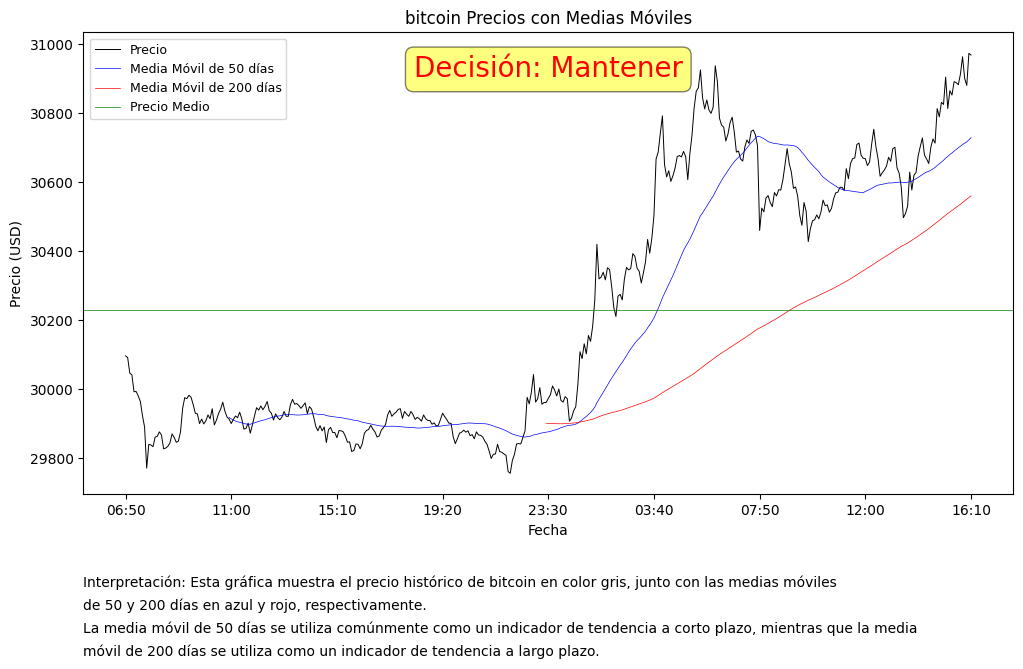

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tiempo de ejecución: 0.02 minutos


<ipython-input-96-87b87d03eb00>:79: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=future_data1, periods=periods, closed='right')
<ipython-input-96-87b87d03eb00>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_data_extended = future_data_extended.append(future_data)
<ipython-input-96-87b87d03eb00>:137: UserWarning: Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax5.legend()


Tiempo de ejecución: 16.04 minutos
('La decisión para este caso es: Mantener, ya que su Explicación: Tendencia bajista pero precio no está lo suficientemente por debajo de media, MA50 y MA200 para justificar una venta adicional. Se recomienda mantener y observar.', None, <Figure size 1000x400 with 1 Axes>, <Figure size 1200x600 with 1 Axes>, 'Ultimos datos de Close                               close\ntime                               \n2023-10-23 14:00:00+00:00  30789.06\n2023-10-23 15:00:00+00:00  30900.35\n2023-10-23 16:00:00+00:00  30962.05\n Predicciones                            predicted_mean\n2023-10-23 17:00:00+00:00    30971.627022\n2023-10-23 18:00:00+00:00    30981.405593\n2023-10-23 19:00:00+00:00    30990.132578\n2023-10-23 20:00:00+00:00    30998.457540\n2023-10-23 21:00:00+00:00    31007.233546\n2023-10-23 22:00:00+00:00    31015.529970\n2023-10-23 23:00:00+00:00    31024.323958\n2023-10-24 00:00:00+00:00    31032.634344\n2023-10-24 01:00:00+00:00    31041.443714\n202

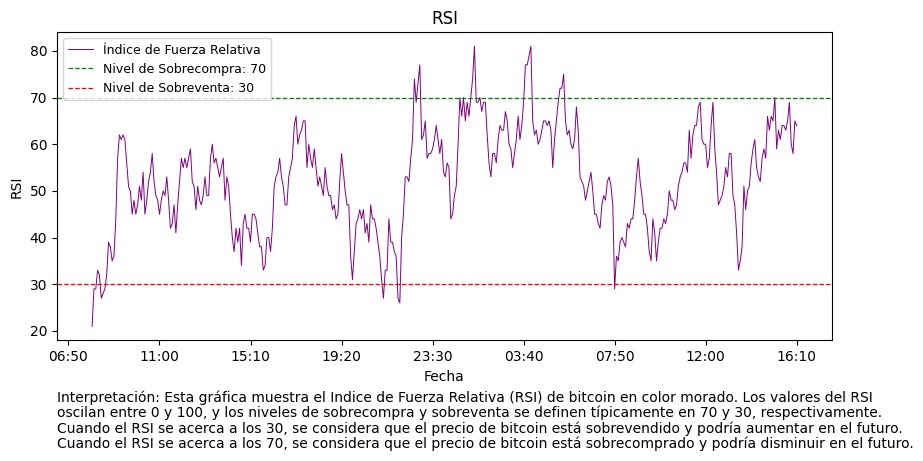

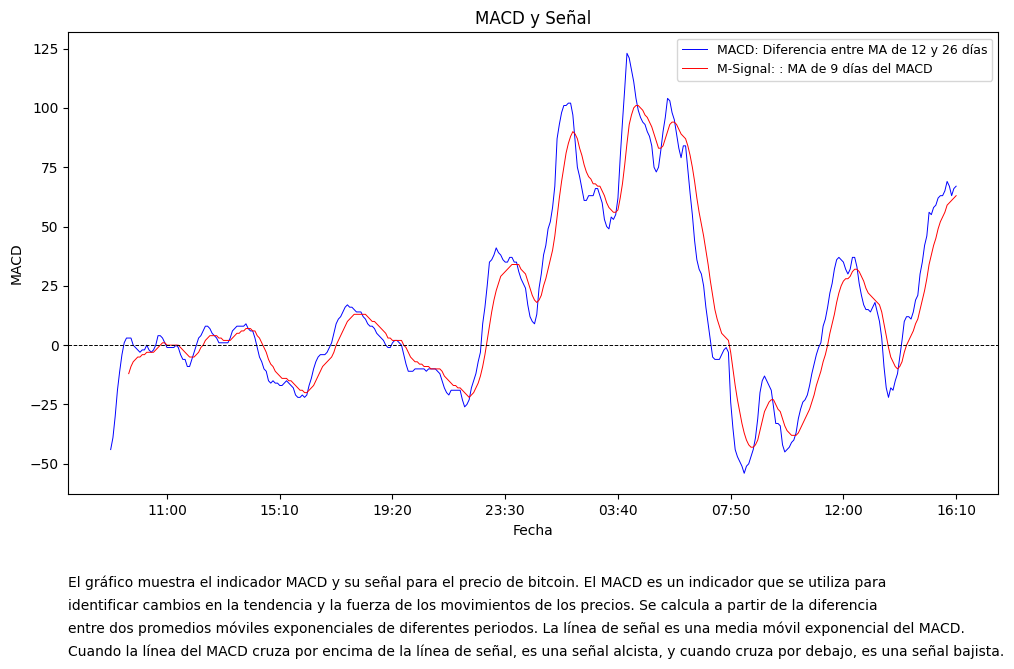

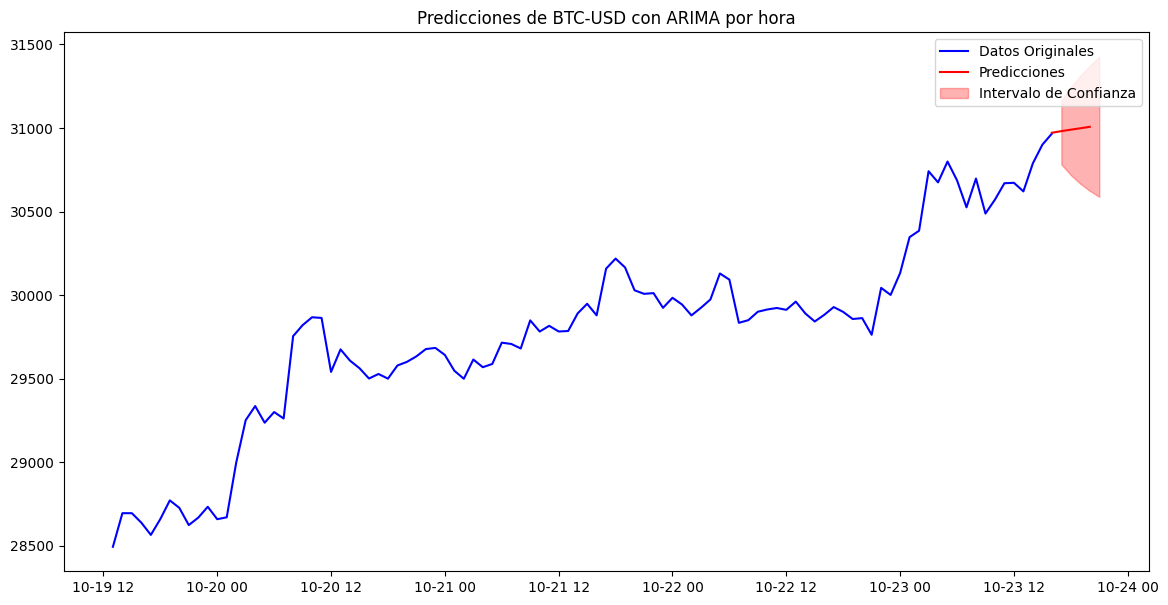

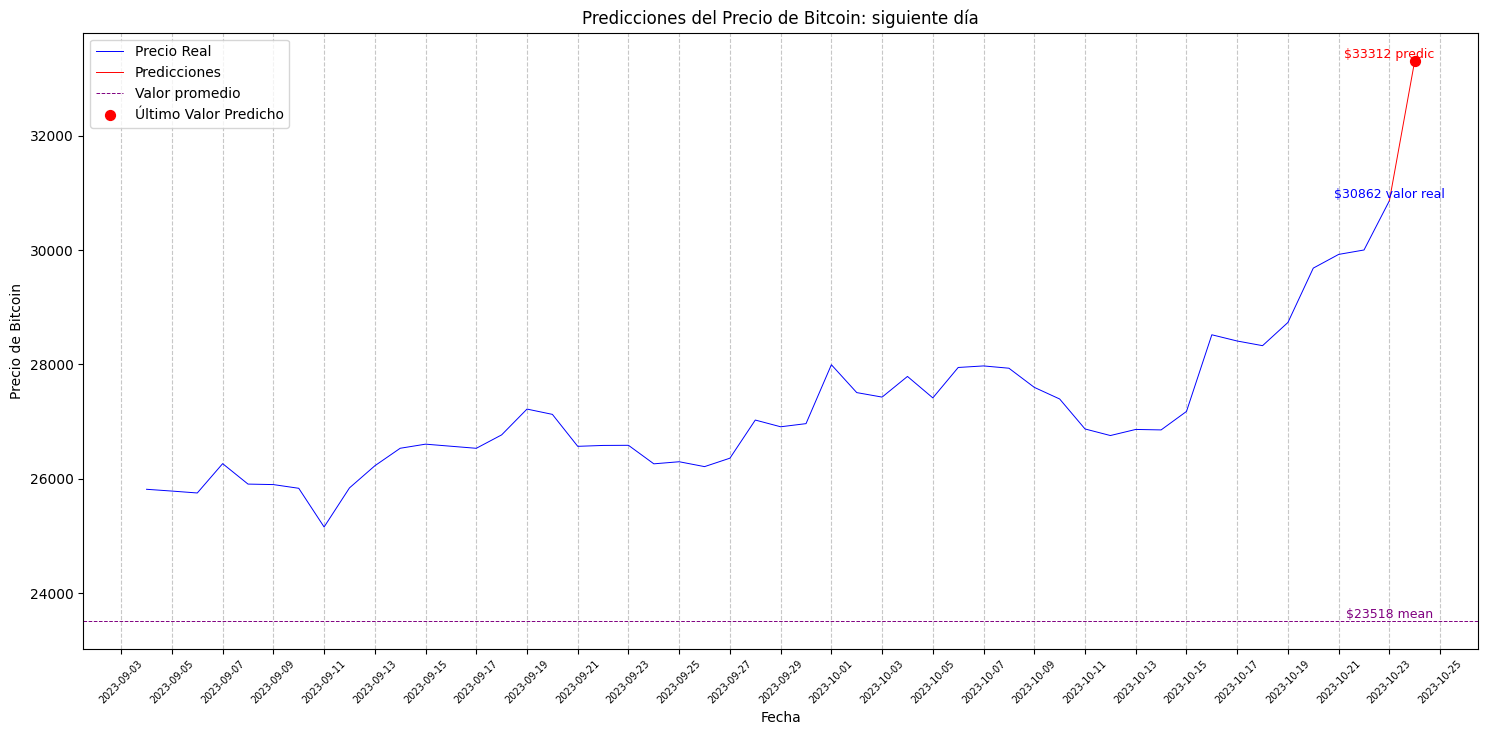

In [100]:
coin = mayus("btc")
btc = get_crypto_info(coin)

print(automatizar(coin, btc))

In [101]:
# !pip freeze > requirements.txt